# Multi-time series forecaster

In univariate time series forecasting, a single time series is modeled as a linear or nonlinear combination of its lags. That is, the past values of the series are used to forecast its future. In multi-time series forecasting, two or more time series are modeled together using a single model. Two strategies can be distinguished:

**No multivariate time series**

A single model is trained, but each time series remains independent of the others. In other words, the past values of one series are not used as predictors of other series. Why is it useful then to model everything together? Although the series do not depend on each other, they may follow the same intrinsic pattern regarding their past and future values. For example, in the same store, the sales of products A and B may not be related, but they follow the same dynamics, that of the store.

<p align="center"><img src="../img/forecaster_multi_series_train_matrix_diagram.png" style="width: 800px"></p>

In order to predict the next *n* steps, the same strategy of [recursive multi-step forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html#multi-step-forecasting) is applied. The only difference is that, the series' name for which to estimate the predictions needs to be indicated.

<p align="center"><img src="../img/forecaster_multi_series_prediction_diagram.png" style="width: 800px"></p>

**Multivariate time series**

All series are modeled in a single model considering that each time series depends not only on its past values but also on the past values of the other series. The forecaster is expected not only to learn the information of each series separately but also to relate them. For example, the measurements made by all the sensors (flow, temperature, pressure...) installed on an industrial machine such as a compressor.

<p align="center"><img src="../img/forecaster_multivariate_train_matrix_diagram.png" style="width: 800px"></p>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4;">

<p class="title">
    <i class="fa-circle-exclamation fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>
    
<code>ForecasterAutoregMultiSeries</code> class covers the use case of No Multivariate time series.

<code>ForecasterAutoregMultivariate</code> will be released in a future version of <b>Skforecast</b> - stay tuned!

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

## Data

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean'})

data.head()

,Demand,Temperature
Time,,
2011-12-31 14:00:00,8646.190700,21.225
2011-12-31 15:00:00,7926.529376,20.625
2011-12-31 16:00:00,7901.826990,20.325
2011-12-31 17:00:00,7255.721350,19.850
2011-12-31 18:00:00,6792.503352,19.025


In [3]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates  : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


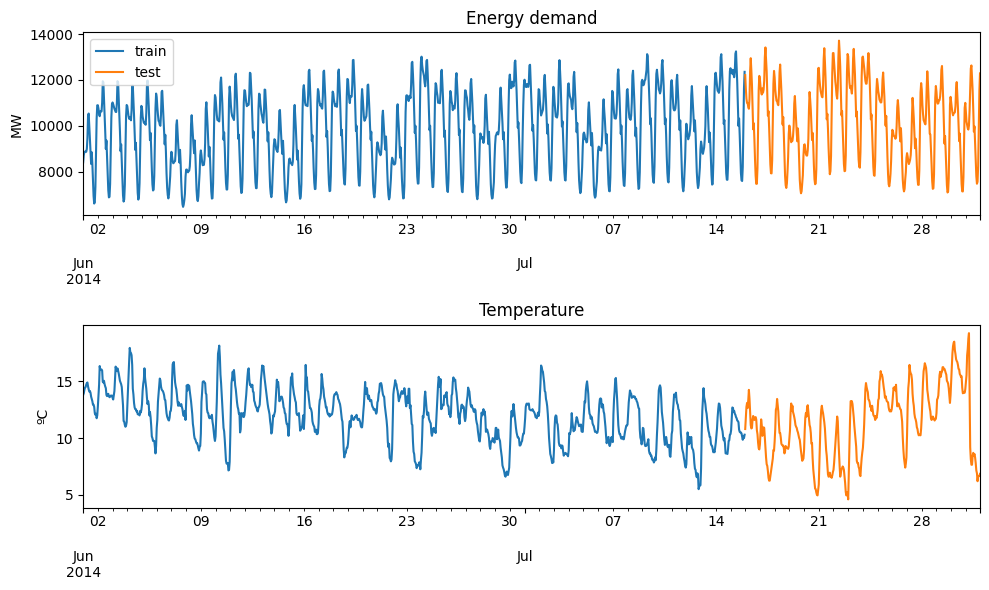

In [4]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_train['Demand'].plot(label='train', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train['Temperature'].plot(label='train', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

## Train and predict ForecasterAutoregMultiSeries

In [5]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None
             )

forecaster.fit(series=data_train[['Demand', 'Temperature']])
forecaster

ForecasterAutoregMultiSeries 
Regressor: LinearRegression() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: {'Demand': None, 'Temperature': None} 
Transformer for exog: None 
Window size: 24 
Series levels: ['Demand', 'Temperature'] 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2014-07-15 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-09-22 13:01:22 
Last fit date: 2022-09-22 13:01:22 
Skforecast version: 0.5.0 
Python version: 3.8.13 

 Two methods can be use to predict the next n steps: `predict()` or `predict_interval()`. The argument `level` is used in order to indicate for which series estimate predictions.

In [6]:
# Predict and predict_interval
# ==============================================================================
steps = 24

# Predictions for Demand
predictions_demand = forecaster.predict(steps=steps, level='Demand')
display(predictions_demand.head(3))

# Interval predictions for Temperature
predictions_temp = forecaster.predict_interval(steps=steps, level='Temperature')
display(predictions_temp.head(3))

2014-07-16 00:00:00    12650.090315
2014-07-16 01:00:00    12481.753017
2014-07-16 02:00:00    12106.341026
Freq: H, Name: pred, dtype: float64

,pred,lower_bound,upper_bound
2014-07-16 00:00:00,10.731159,9.759160,11.701027
2014-07-16 01:00:00,11.267491,9.373177,13.086183
2014-07-16 02:00:00,12.057060,9.589110,14.421818


## Backtesting Multi Series

As in the `predict` method, the `level` at which [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) is performed must be indicated.

In [7]:
# Backtesting Multi Series
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
predictions_demand.head(4)

Backtest error Demand: 571.2243117377157


,pred
2014-07-16 00:00:00,12650.090315
2014-07-16 01:00:00,12481.753017
2014-07-16 02:00:00,12106.341026
2014-07-16 03:00:00,12022.826511


## Hyperparameter tuning and lags selection Multi Series

Functions `grid_search_forecaster_multiseries` and `random_search_forecaster_multiseries` in the module `model_selection_multiseries` allow for lag and hyperparameter optimization. The optimization is performed in the same way as in the other forecasters, [see the user guide here](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html), except for two arguments:

+ `levels_list`: level or levels the forecaster is optimized, for example:

    + If `level_list = ['Demand', 'Temperature']`, the function will search for the lags and hyperparameters that minimize the average error of the predictions of both time series. The resulting metric will be a weighted average of the optimization of both levels. 

    + If `level_list = 'Demand'` (Same as `level_list = ['Demand']`), the function will search for the lags and hyperparameters that minimize the error of the `Demand` predictions.

+ `levels_weights`: weights given to each level during the optimization, for example: 

    + If `level_list = ['Demand', 'Temperature']` and `levels_weights = {'Demand': 0.5, 'Temperature': 0.5}` (Same as `levels_weights = None`), both time series will have the same weight in the calculation of the resulting metric.

The following example shows how to use `grid_search_forecaster_multiseries` to find the best lags and model hyperparameters for both time series:

In [7]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

forecaster.fit(series = data_train[['Demand', 'Temperature']])

In [8]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [24, 48]
param_grid = {'alpha': [0.01, 0.1, 1]}

levels_list = ['Demand', 'Temperature'] # Both time series
levels_weights = {'Demand': 0.5, 'Temperature': 0.5} # Same weight distribution

results = grid_search_forecaster_multiseries(
                forecaster          = forecaster,
                series              = data[['Demand', 'Temperature']],
                lags_grid           = lags_grid,
                param_grid          = param_grid,
                steps               = 24,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(data_train),
                fixed_train_size    = True,
                levels_list         = levels_list,
                levels_weights      = levels_weights,
                exog                = None,
                refit               = True,
                return_best         = False,
                verbose             = False
          )

results

6 models compared for 2 level(s). Number of iterations: 12.
Level weights for metric evaluation: {'Demand': 0.5, 'Temperature': 0.5}


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:07<00:00,  3.79s/it]


,levels,lags,params,mean_absolute_error,alpha
3,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},230.861696,0.01
4,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},230.926321,0.10
5,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},231.564071,1.00
0,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},286.618525,0.01
1,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},286.830534,0.10
2,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},288.908445,1.00


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

Use <b>multiple metrics</b> in the hyperparameter tuning and <code>bayesian_search_forecaster_multiseries</code> will be released in a future version of <b>Skforecast</b>
    
Stay tuned!

</div>

In [8]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>